In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os

%load_ext autoreload
%autoreload 2

In [2]:
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
ampl.set_color_cycle('Oceanic',10)
# plt.style.use('paper')

In [3]:
# data_dir = 'results/weightedRegress_20211127/' # Piyush's results
# data_dir = 'results/weightedRegress_20211206/' # Me replicating his results

data_dir = 'results/ming_tracks_10tr-10val/' # trial run of tracks as nodes



Loading from results/ming_tracks_10tr-10val/


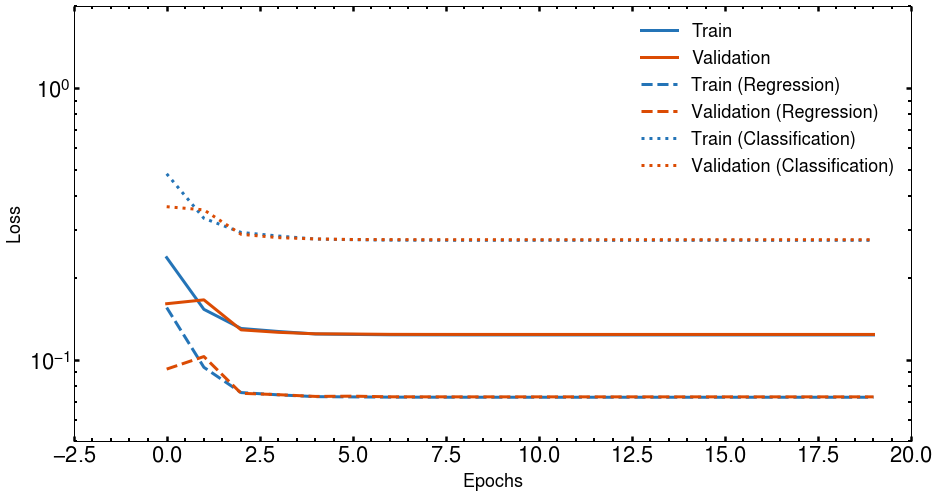

In [5]:
pion_list = ['pion']
sym_list = ['+-',]
concat_type = ['False']
model_name = ['ConcatFalse']
line = ['-', '--', ':']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

plt.figure(figsize=(15,8))
# print('\nPlotting losses fro {}'.format(data_dir))
hist_files = np.sort(glob.glob(data_dir + 'losses.npz'))
print('Loading from {}'.format(data_dir))


hist = np.load(hist_files[0])
plt.semilogy(hist['training'].mean(axis=1), color=blues[5, :3], 
             label=r'Train', linestyle=line[0])
plt.semilogy(hist['validation'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation', linestyle=line[0])

plt.semilogy(hist['training_regress'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Regression)', linestyle=line[1])
plt.semilogy(hist['validation_regress'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Regression)', linestyle=line[1])

plt.semilogy(hist['training_class'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Classification)', linestyle=line[2])
plt.semilogy(hist['validation_class'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Classification)', linestyle=line[2])


plt.ylabel(r'$Loss$')
plt.xlabel(r'$Epochs$')
plt.ylim([5e-2, 2])
# sns.despine()
plt.legend(loc="upper right", fontsize=18)
plt.savefig(data_dir+'/training_mse.png', bbox_inches='tight', dpi=300)
plt.show()

In [6]:
pred_file = data_dir+'/predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets'][:, 0]
targets_class = predictions['targets'][:, 1]
outputs_regress = predictions['outputs'][:, 0]
outputs_class = predictions['outputs'][:, 1]

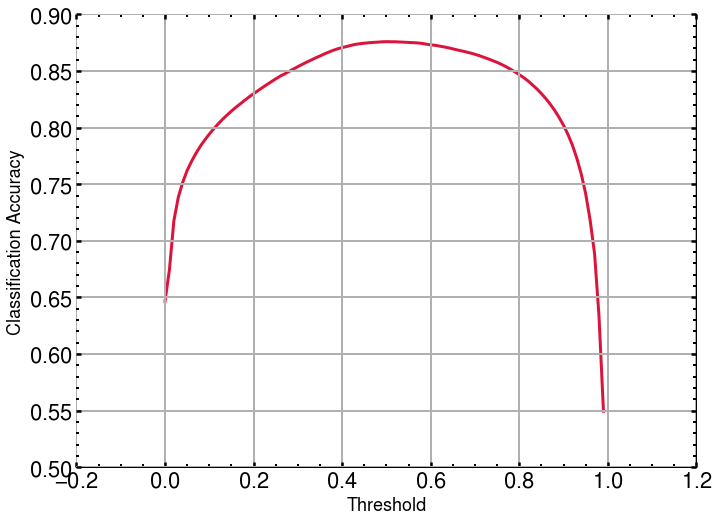

Max Acc: 87.586 at 0.50


In [7]:
acc = []
for i in np.arange(0, 1, .01):
    acc.append(accuracy_score(targets_class, outputs_class>i))
plt.plot(np.arange(0, 1, .01), acc, color="crimson")
plt.xlabel('Threshold')
plt.ylabel('Classification Accuracy')
plt.grid()
plt.savefig(data_dir+'/acc_threshold.png', bbox_inches='tight', dpi=300)
plt.show()
print('Max Acc: {:.3f} at {:.2f}'.format(100*np.max(acc), np.argmax(acc)*.01))

In [8]:
acc = accuracy_score(targets_class, outputs_class>.5)
prec = precision_score(targets_class, outputs_class>.5)
recall = recall_score(targets_class, outputs_class>.5)
f1 = f1_score(targets_class, outputs_class>.5)

print('Acc:\t{:.3f}\nPrec:\t{:.3f}\nRecall:\t{:.3f}\nF1:\t{:.3f}'.format(acc, prec, recall, f1))

Acc:	0.876
Prec:	0.911
Recall:	0.896
F1:	0.903


In [9]:
predictions['targets']

array([[7.9684943e-02, 0.0000000e+00],
       [1.3685037e+02, 1.0000000e+00],
       [2.9773024e+01, 1.0000000e+00],
       ...,
       [1.6641825e+03, 1.0000000e+00],
       [8.9278584e+00, 1.0000000e+00],
       [1.2983824e+02, 0.0000000e+00]], dtype=float32)

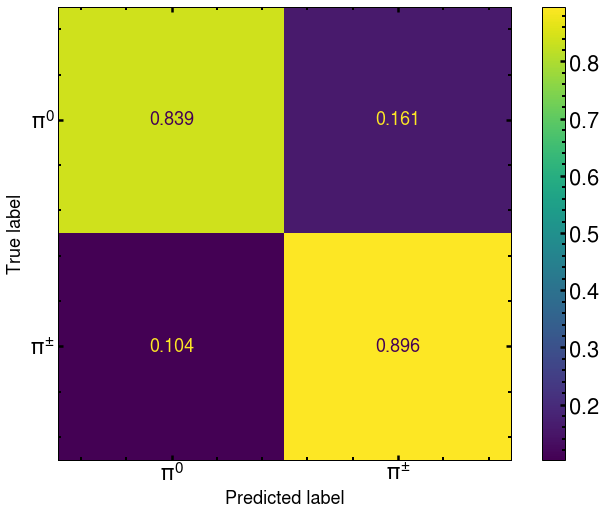

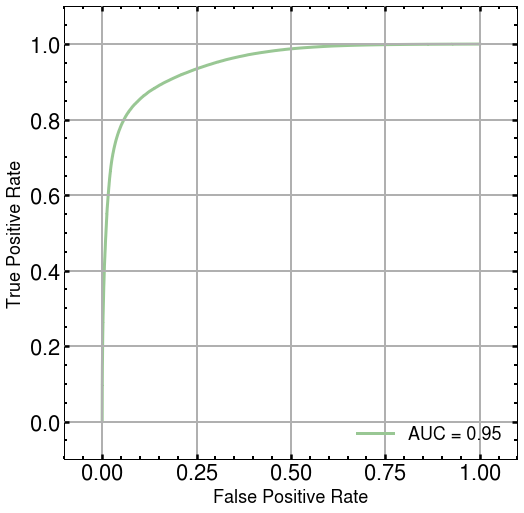

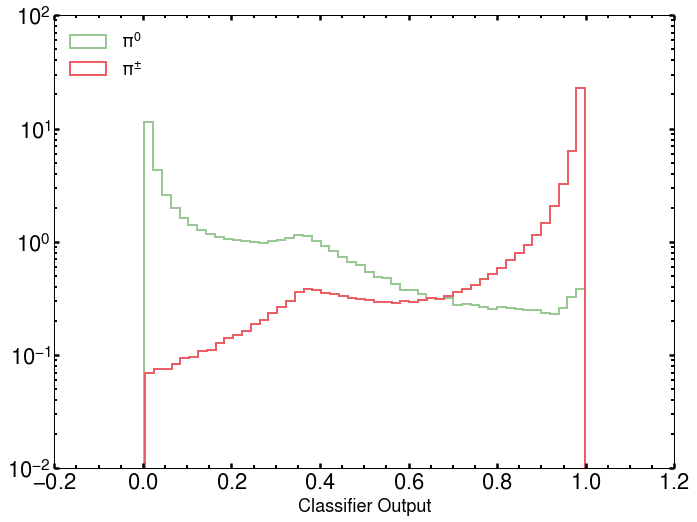

In [10]:
cm = confusion_matrix(targets_class, outputs_class>0.5, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['$\\pi^{0}$', '$\\pi^{\pm}$'])
disp.plot(values_format='.3f')
plt.savefig(data_dir+'/cm.png', dpi=300, bbox_inches='tight')
plt.show()

fpr, tpr, _ = roc_curve(targets_class, outputs_class)
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
# plt.plot(fpr, tpr)
# plt.plot([-.2, 1.2], [-.2, 1.2], 'k')
plt.axis('square')
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.grid()
plt.savefig(data_dir+'/roc_auc.png', dpi=300, bbox_inches='tight')
plt.show()

plt.hist(outputs_class[targets_class==0], 50, density=True, histtype='step', linewidth=2, label='$\\pi^{0}$')
plt.hist(outputs_class[targets_class==1], 50, density=True, histtype='step', linewidth=2, label='$\\pi^{\\pm}$')
plt.legend(loc='upper left')
plt.xlabel('Classifier Output')
plt.yscale('log')
plt.savefig(data_dir+'/class_dist.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_9098/1126804389.py:3: RuntimeWarning: divide by zero encountered in true_divide
  np.nan_to_num(1/fpr),
/global/home/users/mfong/anaconda3/envs/gn4pions/lib/python3.9/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_9098/1126804389.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1000)


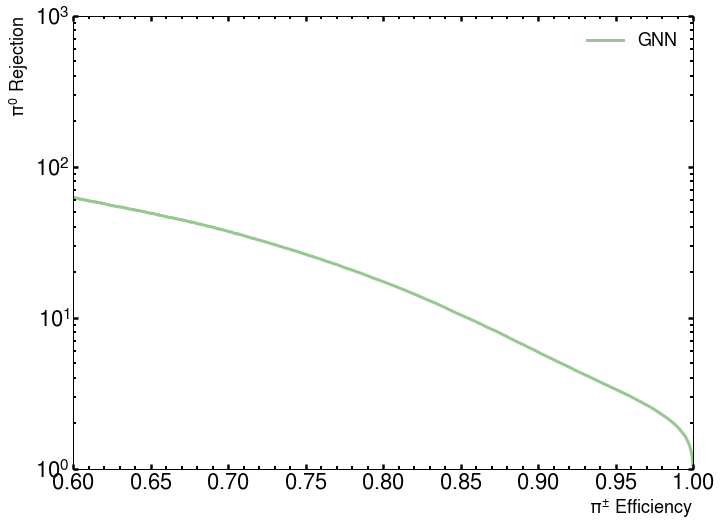

In [11]:
plt.figure()
plt.plot(tpr, 
         np.nan_to_num(1/fpr),
         label = "GNN",
        )
# plt.grid()
plt.xlim(0.6,1)
plt.yscale('log')
plt.ylim(0,1000)
ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
ampl.set_ylabel(r"$\pi^0$ Rejection");
ampl.draw_atlas_label
plt.legend();

In [12]:
def make_response_plot(y_true, y_pred, pion_label, f_name=''):
    y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN


Plotting $\pi^{all}$
r2:0.997
PearsonR:0.998, SpearmanR:0.994, MSE:287.935, MAE:5.020


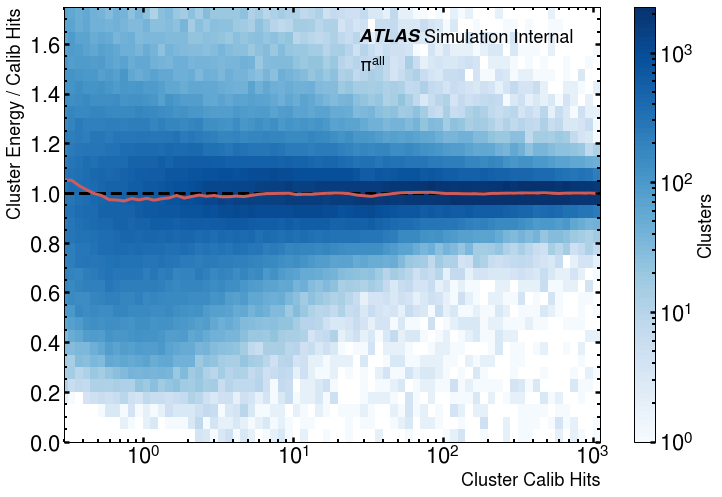


Plotting $\pi^{0}$
r2:0.999
PearsonR:0.999, SpearmanR:0.999, MSE:172.641, MAE:4.548


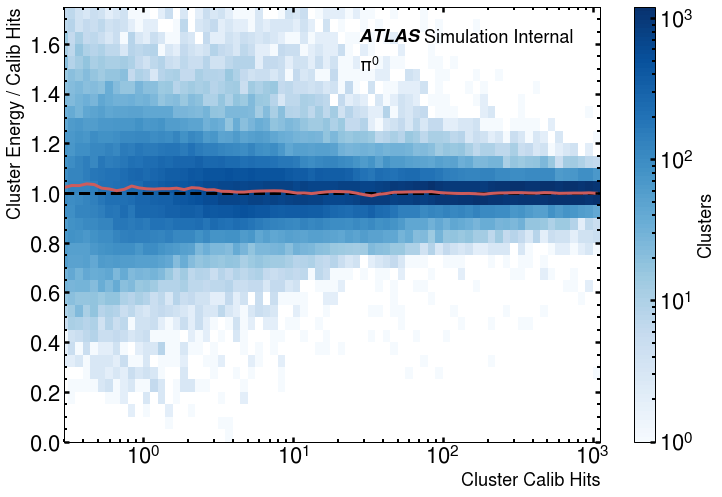


Plotting $\pi^{\pm}$
r2:0.994
PearsonR:0.997, SpearmanR:0.990, MSE:350.959, MAE:5.277


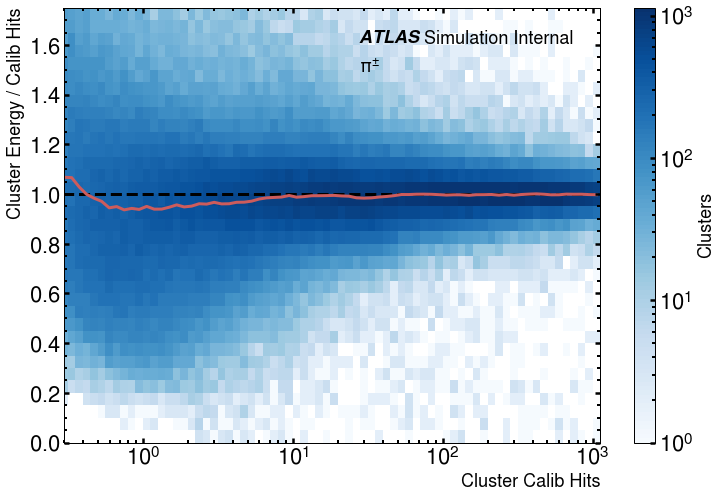

In [13]:
c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
sym_list = ['', '0', '+-']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress
y_pred = outputs_regress
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0])
response_median.append(medRegCNN)

print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1])
response_median.append(medRegCNN)

print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2])
response_median.append(medRegCNN)

np.savez(data_dir+'/response_medians.npz', response_median=response_median, xcenter=xcenter)

extra_line [[0, 10000.0], [1, 1]]


<Figure size 799.992x599.976 with 0 Axes>

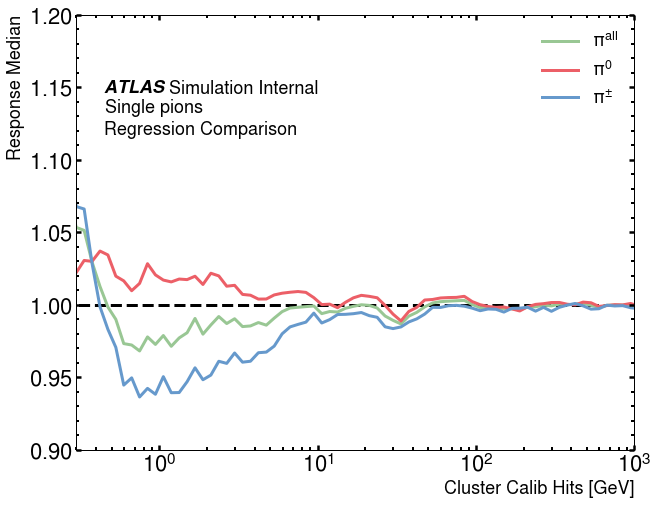

In [14]:
pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response Median',
                figfile = '', # medResponse_gnBlock.png',
                y_max=1.2, y_min=.9, x_min = .3, colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'], # , 'dashed',],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

In [15]:
def make_hist_plot(y_true, y_pred, pion_label, f_name=None):
    print('Wasserstein distance: {:.3f}'.format(wasserstein_distance(y_true, y_pred)))
    fig = plt.figure(figsize=(20,10))
    plt.hist(y_true, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$True$')
    plt.hist(y_pred, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$Predicted$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$Log\ values$')
    plt.ylabel(r'$Counts$')
    plt.xlim([-1.5, 4.])

    atlas_x = 0.55 
    atlas_y = 0.95 
    simulation = True
    textlist = [{'x': 0.55, 'y': 0.88, 'text': pion_label},
                {'x': 0.55, 'y': 0.83, 'text': 'Wasserstein distance: {:.4f}'.format(wasserstein_distance(y_true, y_pred))}]

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)
    # sns.despine()
    if f_name:
        plt.savefig(f_name)
    plt.show()


Plotting $\pi^{all}$
Wasserstein distance: 0.011


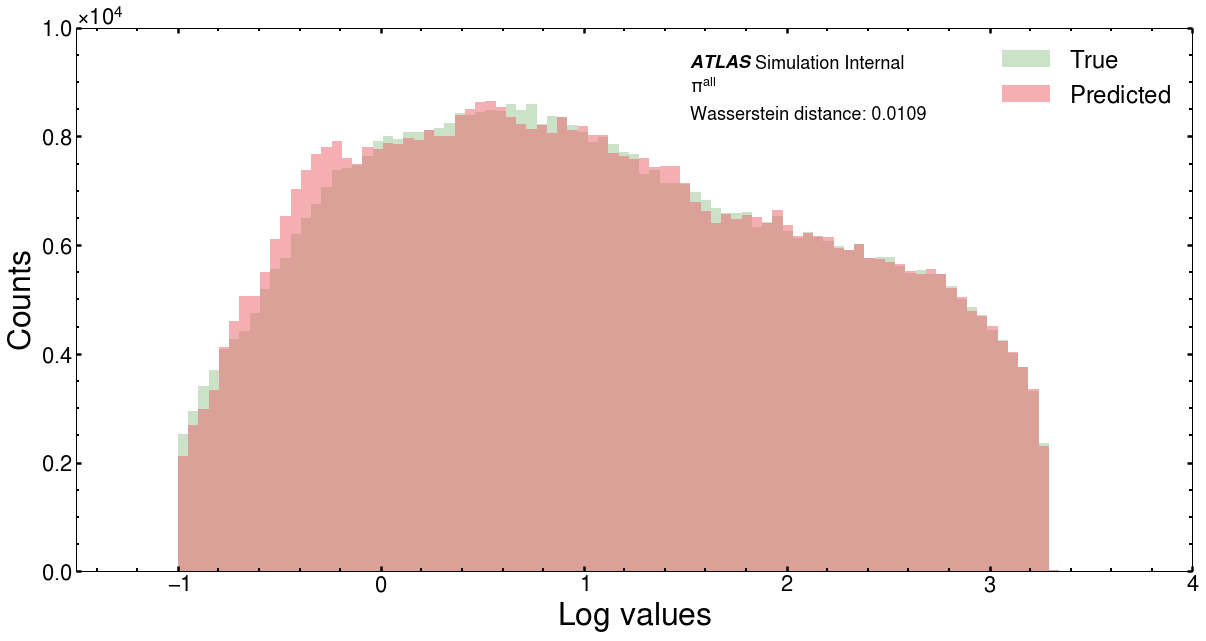


Plotting $\pi^{0}$
Wasserstein distance: 0.005


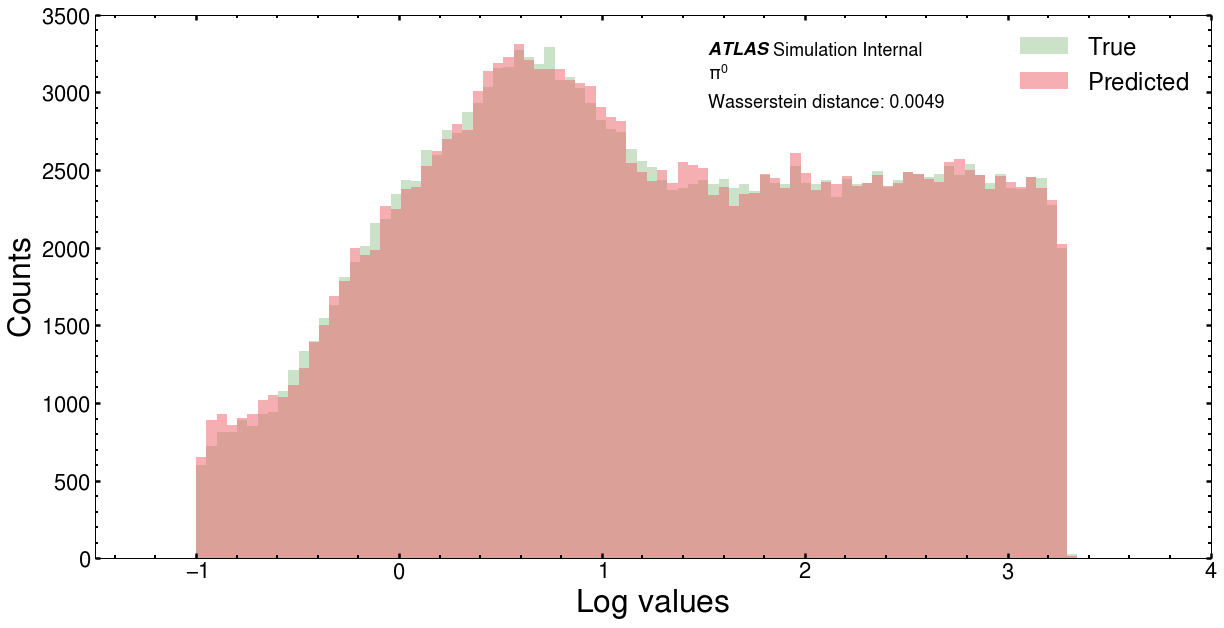


Plotting $\pi^{\pm}$
Wasserstein distance: 0.017


In [ ]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()

# set plotsytle choices here
params = {'legend.fontsize': 24,
          'axes.labelsize': 32}
plt.rcParams.update(params)

ampl.set_color_cycle('Oceanic',10)

c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

print('\nPlotting {}'.format(pion_list[0]))
y_true = np.log10(targets_regress)
y_pred = np.log10(outputs_regress)
make_hist_plot(y_true, y_pred, pion_list[0])

print('\nPlotting {}'.format(pion_list[1]))
y_true = np.log10(targets_regress[targets_class==0])
y_pred = np.log10(outputs_regress[targets_class==0])
make_hist_plot(y_true, y_pred, pion_list[1])

print('\nPlotting {}'.format(pion_list[2]))
y_true = np.log10(targets_regress[targets_class==1])
y_pred = np.log10(outputs_regress[targets_class==1])
make_hist_plot(y_true, y_pred, pion_list[2])

In [ ]:
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress
y_pred = outputs_regress
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

np.savez(data_dir+'/iqr.npz', response_median=iqr, xcenter=xcenter)

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = iqr,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [r'$\pi^{all}$', r'$\pi^{0}$', r'$\pi^{\pm}$'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / 2 x Median',
                figfile = '', # 'iqr_gnBlock.png',
                y_max = .6, x_min = .3,
                linestyles = ['solid', 'solid', 'solid'],  # , 'dashed',],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}])